In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [2]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
device

device(type='cpu')

In [4]:
imsize = (512 if device == 'cuda' else 256)
imsize

256

In [5]:
def load_image (image_path):
  image = Image.open(image_path)
  return image

def resize_image(input_image, output_image):
  input_image_resized = input_image.resize(output_image.size)
  return input_image_resized

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
loader = transforms.Compose([
    transforms.Resize((imsize)),
    transforms.ToTensor(),
])

def process_image(image_name):
    image = loader(image_name).unsqueeze(0)
    return image.to(device, torch.float)

style_image = load_image ("/content/drive/MyDrive/Images/pen.jpg")
content_image = load_image("/content/drive/MyDrive/Images/woman.jpg")
content_image_resized = resize_image(content_image, style_image)
style_img = process_image(style_image)
content_img = process_image(content_image_resized)

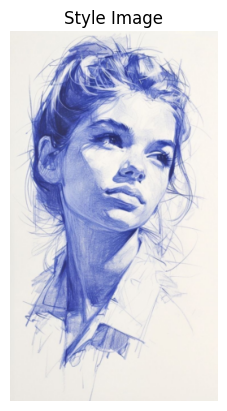

torch.Size([1, 3, 456, 256])


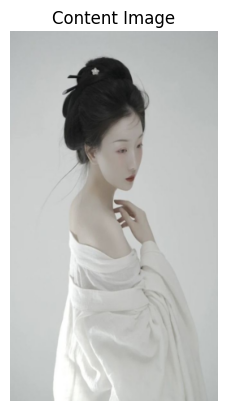

torch.Size([1, 3, 456, 256])


In [6]:
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


plt.figure()
imshow(style_img, title='Style Image')
print (style_img.shape)

plt.figure()
imshow(content_img, title='Content Image')
print (content_img.shape)

In [7]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [8]:
def gram_matrix_via_fft(features):
    b, c, h, w = features.size()
    fft_features = torch.fft.fft2(features, dim=(-2, -1))
    fft_gram = torch.einsum('bchw,bdhw->bcd', fft_features, fft_features.conj())
    fft_gram = fft_gram.real / (h * w)
    fft_gram = fft_gram.real / (h * w)
    return fft_gram

In [9]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix_via_fft(target_feature).detach()

    def forward(self, input):
        G = gram_matrix_via_fft(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [10]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 198MB/s]


In [11]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [12]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn,
                               normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    content_losses = []
    style_losses = []

    normalization = Normalization (normalization_mean, normalization_std)
    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

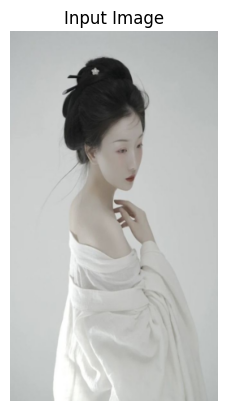

In [13]:
input_img = content_img.clone()
imshow(input_img, title='Input Image')

In [14]:
class EarlyStoppingNST:
    def __init__(self, patience, min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.stop = False

    def __call__(self, current_loss):
        if self.best_loss is None:
            self.best_loss = current_loss
        elif self.best_loss - current_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True
        else:
            self.best_loss = current_loss
            self.counter = 0

In [15]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [16]:
def run_style_transfer_with_beta_grid(cnn,
                                      normalization_mean, normalization_std,
                                      content_img, style_img, input_img,
                                      alpha_value=1e0,
                                      beta_values=[1e4, 1e5, 1e6],
                                      num_steps=1000):
    """Run style transfer with grid search over beta, keeping alpha fixed."""
    print('Building the style transfer model')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
                                                                     normalization_mean, normalization_std,
                                                                     style_img, content_img)

    input_img.requires_grad_(True)
    model.eval()
    model.requires_grad_(False)

    global_best_loss = float('inf')
    global_best_img = input_img.clone()
    global_best_beta = None

    for beta in beta_values:
        print(f"Running style transfer with alpha={alpha_value} and beta={beta}")

        style_weight = beta
        content_weight = alpha_value

        optimizer = get_input_optimizer(input_img)

        run = [0]
        min_loss = float('inf')  # Track the best loss for this beta
        best_img_for_beta = input_img.clone()

        while run[0] <= num_steps:
            def closure():
                with torch.no_grad():
                    input_img.clamp_(0, 1)

                optimizer.zero_grad()
                model(input_img)
                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss

                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 100 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    imshow(input_img)
                    print()

                nonlocal min_loss, best_img_for_beta
                if loss.item() < min_loss:
                    min_loss = loss.item()
                    best_img_for_beta = input_img.clone()

                return loss

            optimizer.step(closure)

        with torch.no_grad():
            input_img.clamp_(0, 1)

        print(f"Finished style transfer with beta={beta}")
        print(f"Minimum loss achieved for beta={beta}: {min_loss}")
        imshow(best_img_for_beta)

        if min_loss < global_best_loss:
            global_best_loss = min_loss
            global_best_img = best_img_for_beta.clone()
            global_best_beta = beta

    print("Minimum loss achieved overall: {:.4f}".format(global_best_loss))
    print(f"Best Beta: {global_best_beta}")
    print("Displaying the image at global minimum loss:")
    imshow(global_best_img)

    return global_best_img

Building the style transfer model


/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Running style transfer with alpha=1.0 and beta=1000.0
run [100]:
Style Loss : 965.211426 Content Loss: 11.286636


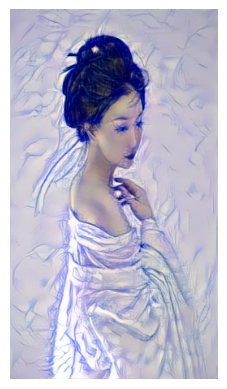


run [200]:
Style Loss : 413.171539 Content Loss: 11.510873


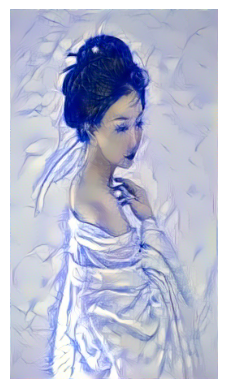


run [300]:
Style Loss : 240.174240 Content Loss: 11.975417


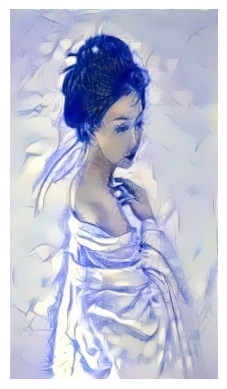


run [400]:
Style Loss : 110.022812 Content Loss: 12.402253


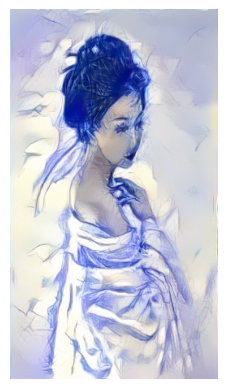


run [500]:
Style Loss : 48.362267 Content Loss: 12.590216


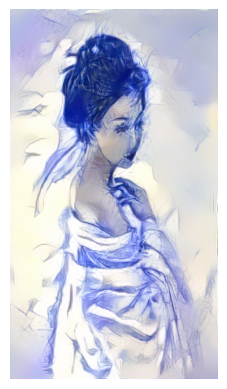


run [600]:
Style Loss : 24.765804 Content Loss: 12.609180


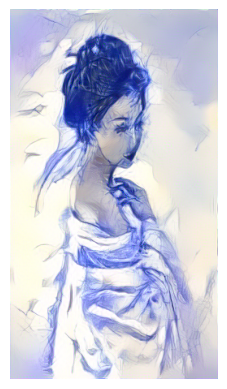


run [700]:
Style Loss : 14.746584 Content Loss: 12.528459


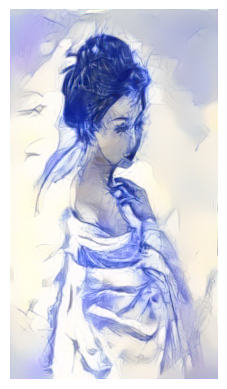


run [800]:
Style Loss : 9.995687 Content Loss: 12.407812


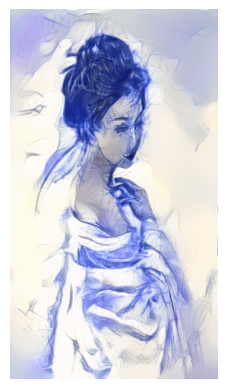


run [900]:
Style Loss : 7.198693 Content Loss: 12.230165


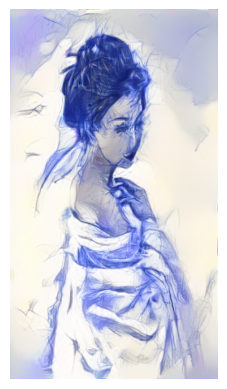


run [1000]:
Style Loss : 5.327376 Content Loss: 12.031054


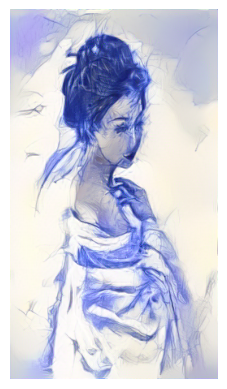


Finished style transfer with beta=1000.0
Minimum loss achieved for beta=1000.0: 17.021194458007812


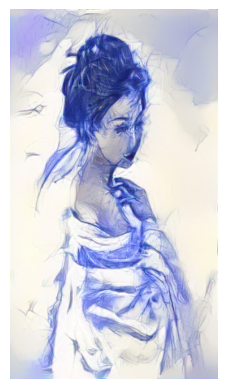

Running style transfer with alpha=1.0 and beta=10000.0
run [100]:
Style Loss : 43.129768 Content Loss: 12.183659


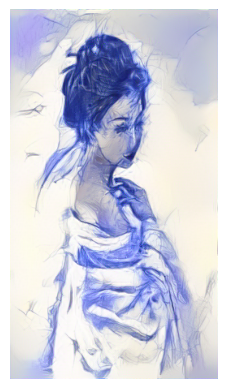


run [200]:
Style Loss : 36.036457 Content Loss: 12.420420


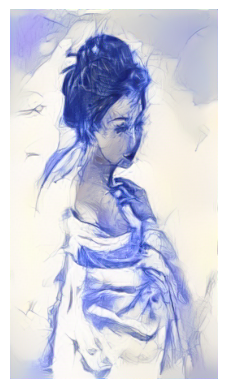


run [300]:
Style Loss : 28.641916 Content Loss: 12.587739


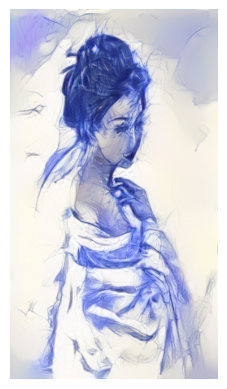


run [400]:
Style Loss : 22.290060 Content Loss: 12.687585


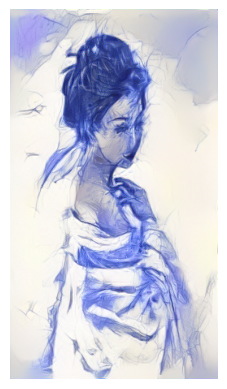


run [500]:
Style Loss : 17.282928 Content Loss: 12.743176


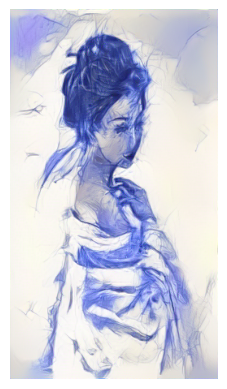


run [600]:
Style Loss : 13.669994 Content Loss: 12.765117


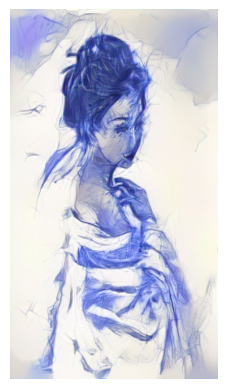

In [ ]:
output = run_style_transfer_with_beta_grid(cnn,
                                          cnn_normalization_mean, cnn_normalization_std,
                                          content_img, style_img, input_img,
                                          alpha_value=1e0,
                                          beta_values=[1e3, 1e4, 1e5],
                                          num_steps=1000)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()
